# Concise representations with the deep decoder

We demonstrate the the deep decoder enables concise representations of images. Towards this goal, we represent an image with an underparametrized deep decoder with $N$ parameters, and for comparison with a wavelet respresentation that retains the $N$ largest wavelet coefficients (i.e., wavelet thresholding). 

We find that if $N$ is small relative to the number of output pixels, the deep decoder performs better (i.e., has smaller representation error).

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pyplot as plt
import numpy as np
import numbers
import pywt
import scipy
import skimage.color as color
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.measure import compare_psnr
import os
from PIL import Image
import PIL
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.optim
from torch.autograd import Variable

from include import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
print("num GPUs",torch.cuda.device_count())
#dtype = torch.FloatTensor

num GPUs 1


## Functions to compute the representation error

In [2]:
def rep_error_deep_decoder(img_np,k=128,convert2ycbcr=False):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    img_var = np_to_var(img).type(dtype)
    
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)
    rnd = 500
    numit = 20000
    rn = 0.005
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.005,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net)

def rep_error_wavelet(img_np,ncoeff=300):
    '''
    mse obtained by representing img_np with wavelet thresholding
    ncoff coefficients are retained per color channel
    '''
    if img_np.shape[0] == 1:
        img_np = img_np[0,:,:]
        out_img_np = denoise_wavelet(img_np, ncoeff=ncoeff, multichannel=False, convert2ycbcr=True, mode='hard')
    else:
        img_np = np.transpose(img_np)
        out_img_np = denoise_wavelet(img_np, ncoeff=ncoeff, multichannel=True, convert2ycbcr=True, mode='hard')
    # img_np = np.array([img_np[:,:,0],img_np[:,:,1],img_np[:,:,2]])
    return psnr(out_img_np,img_np), out_img_np

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')    
        
def comparison(img_np,k,convert2ycbcr=False):
    # compute representations
    psnrv, out_img_np, nparms = rep_error_deep_decoder(img_np,k=k,convert2ycbcr=convert2ycbcr)
    nchannels = img_np.shape[0]
    psnrv_wvl, out_img_np_wvl = rep_error_wavelet(img_np,ncoeff=int(nparms/nchannels))
    
    print("Compression factor: ", np.prod( img_np.shape ) / nparms )
    # plot results
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,out_img_np)
    ax2.set_title( "Deep-Decoder representation, PSNR: %.2f" % psnrv )
    ax2.axis('off')
    #save_np_img(img_np,"exp_comp_orig.png")
    #save_np_img(out_img_np,"exp_comp_dd.png")

    ax3 = fig.add_subplot(133)
    ax3.set_title( "Wavelet representation, PSNR: %.2f" % psnrv_wvl ) 
    ax3.axis('off')
    
    if(img_np.shape[0] == 1):
        ax3.imshow(np.clip(out_img_np_wvl,0,1),cmap='Greys',interpolation='nearest')
    else:
        ax3.imshow(np.clip(out_img_np_wvl.transpose(1, 0, 2) ,0,1))
    
    plt.axis('off')
    fig.show()

In [3]:
def conv(in_f, out_f, kernel_size, stride=1, pad='zero'):
    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        #to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=False)

    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers)

k=64
num_channels = [k]*5
net = decodernw(3,num_channels_up=num_channels).type(dtype)
print(net)

Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): ReLU()
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Upsample(scale_factor=2, mode=bilinear)
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): ReLU()
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Upsample(scale_factor=2, mode=bilinear)
  (9): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Upsample(scale_factor=2, mode=bilinear)
  (13): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (14): 

## Representation error for a color image

The deep decoder performs similarly well when applied to an RGB encoded color image and an YCbCr-encoded image.  In the following experiments, the deep decoder has either k=64 or k=128 channels, and operates on either a RGB or a YCbCr image representation. Wavelet compression performs better in YCbCr space; therefore, we always compare to wavelet thresholding of a YCbCr-encoded image. 

The results show that typically, for a large compression factor, defined as number of output pixels over the number of parameters of the representations, the deep decoder performs better than wavelet thresholding in that it has a smaller representation error. For small compression factors, wavelet thresholding has a smaller representation error.



In [4]:
path = './test_data/'
img_name = "sf4_rgb"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  30.796992481203006 Actual loss 0.003317 Actual loss orig 0.003317  Noise Energy 0.000000 


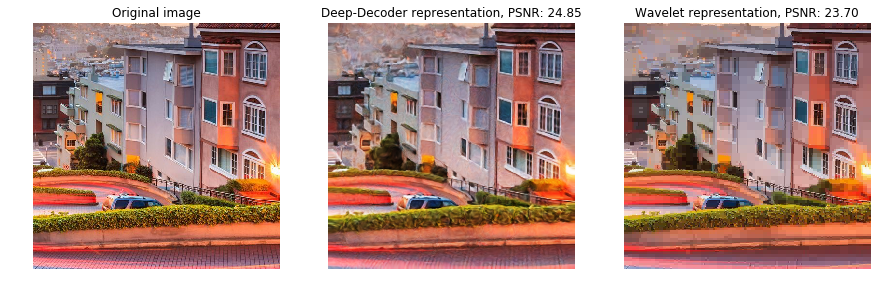

In [5]:
comparison(img_np,64,convert2ycbcr=False)

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  30.796992481203006 Actual loss 0.001273 Actual loss orig 0.001273  Noise Energy 0.000000 


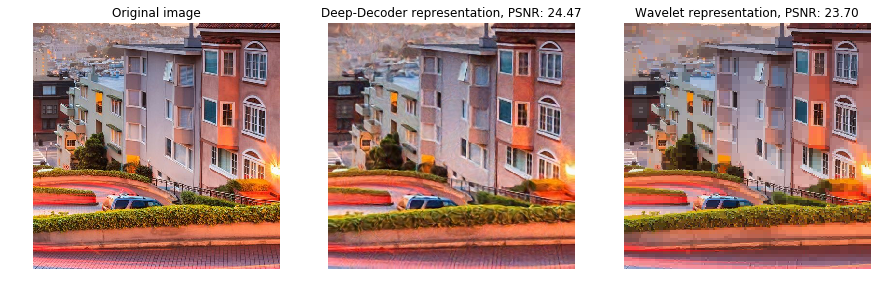

In [6]:
comparison(img_np,64,convert2ycbcr=True)

shape:  [1, 128, 16, 16]
optimize with adam 0.005
Compression factor:  7.846743295019157  Actual loss 0.001467 Actual loss orig 0.001467  Noise Energy 0.000000 


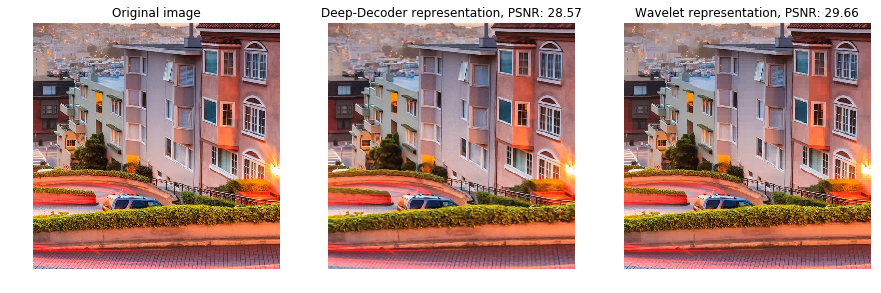

In [7]:
comparison(img_np,128,convert2ycbcr=False)

shape:  [1, 128, 16, 16]
optimize with adam 0.005
Compression factor:  7.846743295019157  Actual loss 0.000610 Actual loss orig 0.000610  Noise Energy 0.000000 


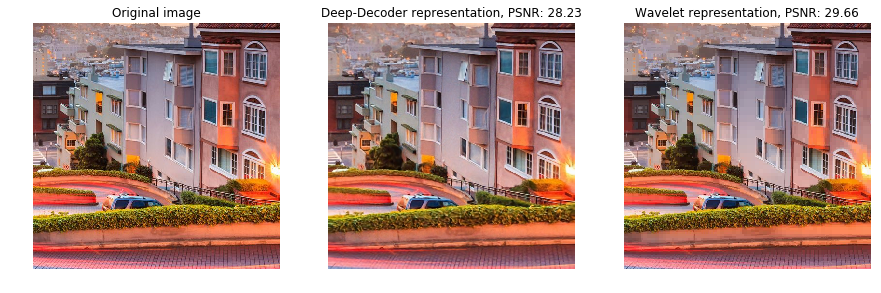

In [8]:
comparison(img_np,128,convert2ycbcr=True)

## Representation error for a grayscale image

In [9]:
path = './test_data/'
img_name = "mri"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

shape:  [1, 32, 16, 16]
optimize with adam 0.005
Compression factor:  39.96097560975618  Actual loss 0.001068 Actual loss orig 0.001068  Noise Energy 0.000000 


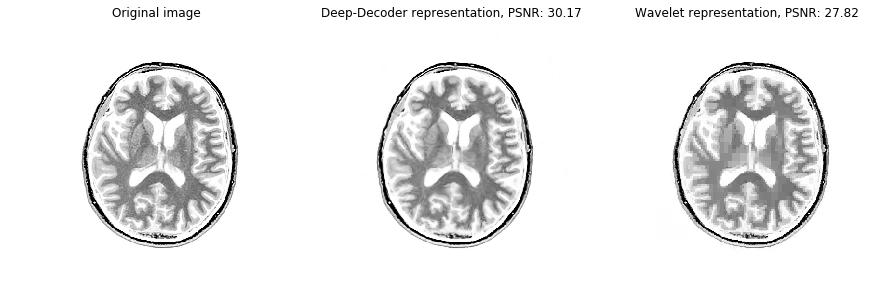

In [10]:
comparison(img_np,32)

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  10.317380352644836 Actual loss 0.000464 Actual loss orig 0.000464  Noise Energy 0.000000 


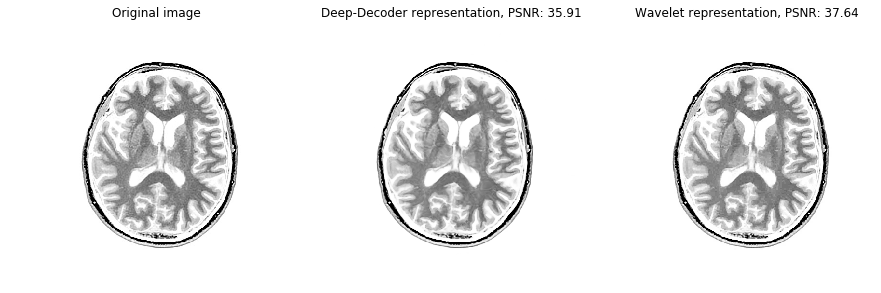

In [11]:
comparison(img_np,64)